# **CSCI 485 Assignment#1: Recursive Feature Elimination with Linear Regression**

## **Task 1: Dataset Exploration**
---

The first step was to load the dataset from the `sklearn.datasets` library and examine its contents.

In [1]:
import pandas as pd
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

print(diabetes.DESCR)
display(X.head())

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


The following diabetes dataset contains 10 different features to explore:

* `age` - Age of the patient
* `sex` - Gender of the patient
* `bmi` - Body Mass Index
* `bp` - Average blood pressure
* `s1` - Total serum cholesterol (TC)
* `s2` - Low-density lipoproteins (LDL)
* `s3` - High-density lipoproteins (HDL)
* `s4` - Total cholesterol / HDL (TCH)
* `s5` - Log of serum triglycerides level (LTG)
* `s6` - Blood sugar level (GLU)

The target variable represents a quantitative measure of disease progression one year after baseline.

Before applying models, the dataset is split into training and testing sets using an 80-20 split.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Task 2: Linear Regression Model**
---

The following code first trains a linear regression model on the training set using all features and then evaluates it on the testing set using the $R^2$ score.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
init_coefficients = pd.Series(lr.coef_, index=X_train_scaled.columns)


y_pred = lr.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"R² Score (All Features): {r2:.4f}")


R² Score (All Features): 0.4526


The current model's performance suggests that 45.26% of the variance in the target variable can be explained using all the features. This means that the model still leaves approximately 54.74% of the variation unexplained.

## **Task 3: Implement Recursive Feature Elimination (RFE)**
---

The following code starts with all 10 features and iteratively eliminates the least important feature until only one feature remains using RFE. R² and coefficient values are tracked for later analysis.

In [5]:
from sklearn.feature_selection import RFE

r2_scores = []
n_features = []
feature_coefficients = []

for i in range(1, X_train_scaled.shape[1] + 1):  
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=i)
    rfe.fit(X_train_scaled, y_train)
    
    r2 = rfe.score(X_test_scaled, y_test)
    r2_scores.append(r2)
    n_features.append(i)
    
    selected_features = X_train_scaled.columns[rfe.support_]
    coefficients = pd.Series(rfe.estimator_.coef_, index=selected_features)
    feature_coefficients.append(coefficients)

The following figure plots the R² values as the number of features increases. This provides a visual representation of where an optimal number of features may lie compared to using other feature counts.

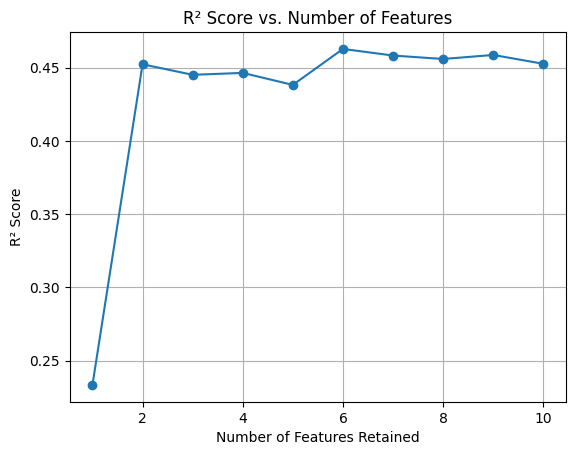

In [6]:
import matplotlib.pyplot as plt

plt.plot(n_features, r2_scores, marker='o', linestyle='-')
plt.xlabel("Number of Features Retained")
plt.ylabel("R² Score")
plt.title("R² Score vs. Number of Features")
plt.grid(True)
plt.show()

When using a threshold of 0.1, this indicates that 2 features are optimal, as adding more does not result in significant changes.

In [8]:
import numpy as np

threshold = 0.01 
optimal_features = n_features[np.argmax(np.diff(r2_scores) < threshold)]
print("Optimal #Features:", optimal_features)

Optimal #Features: 2


## **Task 4: Analyze Feature Importance**
---

The table below shows the features at each iteration of RFE.

In [9]:
coef_df = pd.DataFrame(feature_coefficients).transpose()
coef_df.columns = [f"{i} features" for i in n_features]
display(coef_df)

,1 features,2 features,3 features,4 features,5 features,6 features,7 features,8 features,9 features,10 features
bmi,47.141122,34.561598,34.824858,32.642633,28.225480,26.309836,26.052658,25.999687,25.624624,25.607121
s5,NaN,26.852197,32.487841,37.404489,34.800355,38.357441,31.749939,36.389705,35.555151,35.161195
s1,NaN,NaN,-10.895940,-28.295763,-31.282091,-40.632693,-31.524621,-45.228296,-44.680849,-44.448856
s2,NaN,NaN,NaN,17.263257,19.483143,28.114579,16.330902,25.759819,25.151517,24.640954
bp,NaN,NaN,NaN,NaN,14.841764,16.948653,17.538042,17.607527,17.143839,16.828872
sex,NaN,NaN,NaN,NaN,NaN,-10.241663,-11.197798,-11.121222,-11.258951,-11.511809
s4,NaN,NaN,NaN,NaN,NaN,NaN,8.835330,13.254423,12.903924,13.138784
s3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.091813,7.882757,7.676978
s6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.577454,2.351364
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.753758


When comparing the initial and final features after applying RFE, the coefficients show slight changes for each feature, with age being dropped at the end. The top three features suggest that Total Serum Cholesterol (s1), Log of Serum Triglycerides Level (s5), and Body Mass Index (BMI) have the most impact on disease progression one year after baseline, compared to the other features.

In [10]:
init_features = init_coefficients.abs().sort_values(ascending=False)
print("\nInitial Features:\n", init_features)

final_features = coef_df.iloc[:, -optimal_features].abs().sort_values(ascending=False)
print("\nFinal Features:\n", final_features)

top_features = init_features.head(3).index.tolist()
print("\nTop Three Most Important Features:\n", top_features)



Initial Features:
 s1     44.448856
s5     35.161195
bmi    25.607121
s2     24.640954
bp     16.828872
s4     13.138784
sex    11.511809
s3      7.676978
s6      2.351364
age     1.753758
dtype: float64

Final Features:
 s1     44.680849
s5     35.555151
bmi    25.624624
s2     25.151517
bp     17.143839
s4     12.903924
sex    11.258951
s3      7.882757
s6      2.577454
age          NaN
Name: 9 features, dtype: float64

Top Three Most Important Features:
 ['s1', 's5', 'bmi']


## **Task 5: Reflection**
---

### **What did I learn about RFE**
Recursive Feature Elimination is a neat algorithm that iteratively removes the least important features and evaluates the model's performance along the way. This can lead to discovering the most important features for a target variable and also reduce computational cost in further analysis by utilizing only the optimal number of features compared to the entire dataset. This is definitely something I will remember and utilize when handling datasets and their feature importance.

### **How does it compare to LASSO**
Unlike using an iterative approach to remove features one at a time, LASSO uses a regularization technique that applies an L1 penalty to the regression coefficients. It doesn't require multiple iterations, and the number of features selected depends on the strength of the penalty parameter. Therefore, LASSO is more ideal for larger datasets with many features, as it is more direct and less computationally expensive. However, RFE does offer more control since you go through each iteration of removing a feature one at a time.

### **Insights about the dataset and selected features**
Based on the optimal number of features selected by the model, Total Serum Cholesterol (s1) and Log of Serum Triglycerides Level (s5) have the highest impact on disease progression one year after baseline, compared to the other features. However, I would like to point out that when graphing the R² values against the number of features retained, I found it odd that sometimes the R² value would drop when the number of features increased. My current understanding of the subject is that more features mean more data to explain the variability. Therefore, R² should continue to rise as more features are included. I would like to review this report with someone else to validate my results.